<a href="https://colab.research.google.com/github/thiagolaitz/IA368-search-engines/blob/main/Project%2002/minilm_ranker_ia368.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this Colab notebook, we will be fine-tuning a small BERT model, the pre-trained MiniLM-L6-H384-uncased model from HuggingFace (MiniLM) on a subset of the MS MARCO dataset which is a large-scale information retrieval dataset that contains real-world, user-generated queries and documents. The goal of this task is to retrieve relevant documents for each query.

Our focus will be on evaluating the performance of MiniLM on the TREC Deep Learning 2020 evaluation framework to evaluate the performance of MiniLM. TREC DL 2020 is an evaluation campaign for information retrieval and natural language processing systems.

Fine-tuning a pre-trained model like MiniLM on a task-specific dataset like MS MARCO can result in improved performance for that task. We will walk through all the steps of fine-tuning the model over the 11k triples and evaluating its performance.

***********************************************

IMPORTANT: It is recommended to use a GPU for running this colab

In [1]:
# Visualize the GPU being used
!nvidia-smi

Sun Mar 12 17:46:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Libraries (finetuning)

In [2]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 77.7 MB/s eta 0:00:00


In [3]:
import os

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from dataclasses import dataclass

from tqdm.notebook import tqdm

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BatchEncoding,
    get_linear_schedule_with_warmup
)

## Libraries (evaluation)

In [4]:
!pip install pyserini -q
!pip install faiss-cpu==1.7.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.1/137.1 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 KB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 59.8 MB/s eta 0:00:00


In [5]:
from collections import defaultdict
from typing import List

from pyserini.search import get_topics
from pyserini.search.lucene import LuceneSearcher

# Corpus

The 11k triples of the MSMARCO dataset subset refer to a collection of approximately 11,000 triples consisting of a query, a relevant passage, and a non-relevant passage. The triples in this subset have been manually annotated and are often used for training and evaluating information retrieval and natural language processing models.

In [6]:
!wget https://storage.googleapis.com/unicamp-dl/ia368dd_2023s1/msmarco/msmarco_triples.train.tiny.tsv

--2023-03-12 17:47:05--  https://storage.googleapis.com/unicamp-dl/ia368dd_2023s1/msmarco/msmarco_triples.train.tiny.tsv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8076179 (7.7M) [text/tab-separated-values]
Saving to: ‘msmarco_triples.train.tiny.tsv’

msmarco_triples.tra 100%[===================>]   7.70M  8.45MB/s    in 0.9s    

2023-03-12 17:47:06 (8.45 MB/s) - ‘msmarco_triples.train.tiny.tsv’ saved [8076179/8076179]



## Triples

The file contains 11k triples, each consisting of a query along with a relevant and non-relevant passage. For our purposes, we will use 10k triples for training and 1k for validation.

In [7]:
!wc -l msmarco_triples.train.tiny.tsv

11000 msmarco_triples.train.tiny.tsv


In [8]:
# 10k lines for training
!head -n 10000 "msmarco_triples.train.tiny.tsv" > "msmarco_tiny_train.tsv"

# 1k lines for validation
!tail -n 1000 "msmarco_triples.train.tiny.tsv" > "msmarco_tiny_val.tsv"

## Sample

In [9]:
!head -n 2 msmarco_triples.train.tiny.tsv

is a little caffeine ok during pregnancy	We donât know a lot about the effects of caffeine during pregnancy on you and your baby. So itâs best to limit the amount you get each day. If youâre pregnant, limit caffeine to 200 milligrams each day. This is about the amount in 1Â½ 8-ounce cups of coffee or one 12-ounce cup of coffee.	It is generally safe for pregnant women to eat chocolate because studies have shown to prove certain benefits of eating chocolate during pregnancy. However, pregnant women should ensure their caffeine intake is below 200 mg per day.
what fruit is native to australia	Passiflora herbertiana. A rare passion fruit native to Australia. Fruits are green-skinned, white fleshed, with an unknown edible rating. Some sources list the fruit as edible, sweet and tasty, while others list the fruits as being bitter and inedible.assiflora herbertiana. A rare passion fruit native to Australia. Fruits are green-skinned, white fleshed, with an unknown edible rating. Some sou

# Dataloader

In this section, we will create a PyTorch DataLoader using the tokenized queries and passages from our MSMARCO dataset. The DataLoader will allow us to efficiently load the data into our neural network model during training and validation.

## Tokenizer
In the field of information retrieval, a cross-encoder is a specific type of neural network architecture that takes two inputs, typically a query and a document, and generates a single output that represents the relevance score of the document for the given query. Unlike traditional information retrieval models, which rely on a pre-defined similarity metric between queries and documents, cross-encoders learn to encode the semantic meaning of both the query and the document into a joint representation space.

In our specific case, we plan to fine-tune the pre-trained MiniLM-L6-H384-uncased model with this objective in mind. To encode documents and queries, we recommend using the tokenizer provided by HuggingFace and applying the appropriate encoding pattern with a special seperator token between the query and the passage:

[CLS] query [SEP] passage [SEP]

In [10]:
tokenizer = AutoTokenizer.from_pretrained("nreimers/MiniLM-L6-H384-uncased")

## Example



In [11]:
query = "is a little caffeine ok during pregnancy"
doc = "We dont know a lot about the effects of caffeine during pregnancy on you and your baby."

encoded_input = tokenizer(query, doc, add_special_tokens=True, max_length=256, truncation=True, return_attention_mask=True)
encoded_input

{'input_ids': [101, 2003, 1037, 2210, 24689, 7959, 3170, 7929, 2076, 10032, 102, 2057, 2123, 2102, 2113, 1037, 2843, 2055, 1996, 3896, 1997, 24689, 7959, 3170, 2076, 10032, 2006, 2017, 1998, 2115, 3336, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [12]:
decoded_input = tokenizer.decode(encoded_input["input_ids"])
print(decoded_input)

[CLS] is a little caffeine ok during pregnancy [SEP] we dont know a lot about the effects of caffeine during pregnancy on you and your baby. [SEP]


## Custom Dataset

In [13]:
class QueryDocuments(Dataset):
    def __init__(self, file_path, tokenizer, total):
        """
        file_path: The path with the collection file
        tokenizer: The HuggingFace tokenizer
        total: The ammount of documents in the file
        """
        self.tokenizer = tokenizer
        self.total = total
        self.dataset = self.load_dataset(file_path)

    def tokenize(self, query: str, doc: str, relevant: int):
        """
        Tokenize a query and document.
        Args:
            query: the query text
            doc: the passage text
            relevat: whether the passage is relevant to the query
        Returns:
            A dict containing the input_ids, token_type_ids, attention_mask
            and label
        """
        encoded_input = self.tokenizer(
            query,
            doc,
            add_special_tokens=True,
            max_length=256,
            truncation=True,
            return_attention_mask=True
        )
        encoded_input["labels"] = relevant
        return encoded_input

    def load_dataset(self, file_path: str):
        """
        Loads the dataset into memory. 
        As it is a small dataset, it fits entirely in memory
        """
        dataset = []
        with open(file_path, "r") as fin:
            for line in tqdm(fin, desc="Loading dataset", total=self.total):
                query, pos_doc, neg_doc = line.strip().split("\t")
                dataset.append(self.tokenize(query, pos_doc, 1))
                dataset.append(self.tokenize(query, neg_doc, 0))
        return dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

In [14]:
train_dataset = QueryDocuments("/content/msmarco_tiny_train.tsv", tokenizer, 10000)
val_dataset = QueryDocuments("/content/msmarco_tiny_val.tsv", tokenizer, 1000)

Loading dataset:   0%|          | 0/10000 [00:00<?, ?it/s]

Loading dataset:   0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
# This functions adds "pad" tokens to examples in the batch that are shorter than the largest one.
def collate_fn(batch):
    return BatchEncoding(tokenizer.pad(batch, return_tensors='pt'))

# Convert examples to Pytorch's DataLoader.
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Trainer

This section writes a trainer to handle the finetuning training and validation

In [45]:
class Trainer():
    def __init__(
        self,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        model_name_or_path: str = "nreimers/MiniLM-L6-H384-uncased",
        batch_size: int = 32,
        lr: float = 2e-5,
        epochs: int = 5,
        save_dir: str = "./finetuned_model"
    ):
        """
        Creates an instance of the Trainer class using the provided training/validation
        parameters. By default, it uses the AdamW optimizer.
        """         
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.epochs = epochs
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        num_training_steps = self.epochs * len(self.train_dataloader)
        # Uses 10% of training steps as warmup steps
        num_warmup_steps = int(num_training_steps * 0.1)

        # Gets the model from the AutoModelForSequenceClassification class
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path).to(self.device)
        self.optimizer = optim.AdamW(self.model.parameters(), lr=lr)
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps, num_training_steps)

        # Saves the model with the best val loss
        self.save_dir = save_dir
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

    def evaluate(self):
        """
        Evaluates the model in the test Dataloader.
        Returns:
            Validation loss and Validation accuracy
        """
        losses = []
        correct = 0
        # Sets the model in the eval mode
        self.model.eval()
        with torch.no_grad():
            for batch in self.val_dataloader:
                outputs = self.model(**batch.to(self.device))
                batch_loss = outputs.loss
                losses.append(batch_loss.cpu().item())
                preds = outputs.logits.argmax(dim=1)
                correct += (preds == batch['labels']).sum().item()

        val_loss = sum(losses) / len(losses)
        val_acc = correct / len(self.val_dataloader.dataset)
        print(f'Val loss: {val_loss:0.3f}; accuracy: {val_acc:0.3f}')
        return val_loss, val_acc

    def fit(self):
        """
        Trains the fine-tuning model on the specified dataset.

        This method iterates over the number of epochs specified during instantiation, and trains the model
        using the provided training dataloader. It also calculates the validation loss and accuracy on the
        validation set after each epoch. The best model according to the validation loss is saved.

        Returns:
        train_losses (list[float]): The training loss for each epoch.
        val_losses (list[float]): The validation loss for each epoch.
        val_accuracy (list[float]): The validation accuracy for each epoch.
        """
        train_losses = []
        val_losses = []
        val_accuracy = []

        for epoch in tqdm(range(self.epochs), desc='Epochs'):
            batch_losses = []
            # Sets the model in the training mode
            self.model.train()

            for batch in self.train_dataloader:
                self.optimizer.zero_grad()
                outputs = self.model(**batch.to(self.device))
                batch_loss = outputs.loss
                batch_loss.backward()
                self.optimizer.step()
                self.scheduler.step()
                batch_losses.append(batch_loss.cpu().item())

            epoch_loss = sum(batch_losses)/len(batch_losses)
            print(f"Training loss: {epoch_loss:.3f}")

            # Evaluates the model
            val_loss, val_acc = self.evaluate()

            # Append losses and accuracy
            val_losses.append(val_loss)
            val_accuracy.append(val_acc)
            train_losses.append(epoch_loss)

            self.model.save_pretrained(self.save_dir)

            print("*" * 60)
        return train_losses, val_losses, val_accuracy


## Fit

Prints the training evolution over the epochs

In [46]:
trainer = Trainer(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=5
)

training_loss, val_loss, val_accuracy = trainer.fit()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nreimers/MiniLM-L6-H384-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training loss: 0.595
Val loss: 0.403; accuracy: 0.832
************************************************************
Training loss: 0.321
Val loss: 0.315; accuracy: 0.870
************************************************************
Training loss: 0.230
Val loss: 0.344; accuracy: 0.859
************************************************************
Training loss: 0.176
Val loss: 0.374; accuracy: 0.869
************************************************************
Training loss: 0.146
Val loss: 0.388; accuracy: 0.866
************************************************************


## Plots

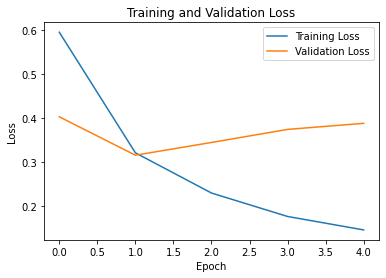

In [47]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss on the same plot
ax.plot(training_loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')

# Set the plot title and labels
ax.set_title('Training and Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Add a legend to the plot
ax.legend()

# Display the plot
plt.show()

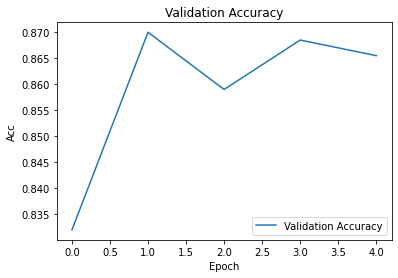

In [48]:
# Plots the accuracy

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss on the same plot
ax.plot(val_accuracy, label='Validation Accuracy')

# Set the plot title and labels
ax.set_title('Validation Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Acc')

# Add a legend to the plot
ax.legend()

# Display the plot
plt.show()

# Evaluation on TRECDL-2020



In [20]:
# Downloads the MsMarco dataset
!wget https://msmarco.blob.core.windows.net/msmarcoranking/collectionandqueries.tar.gz -P collections/msmarco-passage
!tar xvfz collections/msmarco-passage/collectionandqueries.tar.gz -C collections/msmarco-passage

--2023-03-12 17:56:17--  https://msmarco.blob.core.windows.net/msmarcoranking/collectionandqueries.tar.gz
Resolving msmarco.blob.core.windows.net (msmarco.blob.core.windows.net)... 20.150.34.4
Connecting to msmarco.blob.core.windows.net (msmarco.blob.core.windows.net)|20.150.34.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1057717952 (1009M) [application/gzip]
Saving to: ‘collections/msmarco-passage/collectionandqueries.tar.gz’

collectionandquerie 100%[===================>]   1009M  6.69MB/s    in 3m 36s  

2023-03-12 17:59:53 (4.68 MB/s) - ‘collections/msmarco-passage/collectionandqueries.tar.gz’ saved [1057717952/1057717952]

collection.tsv
qrels.dev.small.tsv
qrels.train.tsv
queries.dev.small.tsv
queries.dev.tsv
queries.eval.small.tsv
queries.eval.tsv
queries.train.tsv


In [21]:
# Get the dictionary containing the IDs of the queries and their texts.
topics = get_topics('dl20')

## BM25 Run
Since the entire collection contains almost 9 million passages, it is infeasible to rank all the documents for each query. Therefore, we should use a faster algorithm such as BM25 in the first ranking stage, which will provide 1000 passage candidates for each query. These candidates will then be reranked using the fine-tuned model.

TREC run format: qid Q0 doc_id rank score label

In [22]:
searcher = LuceneSearcher.from_prebuilt_index('msmarco-passage')

def get_run(path: str, topics: dict, top_k: int, searcher):
    """
    This function writes a run in the given path containing the 

    """
    with open(path, 'w') as fout:
        for id in tqdm(topics, desc="Running queries"):
            query = topics[id]['title']
            hits = searcher.search(query, top_k)
            for idx, hit in enumerate(hits):
              fout.write(f"{id}\tQ0\t{hit.docid}\t{idx+1}\t{hit.score}\tBM25\n")

index-msmarco-passage-20201117-f87c94.tar.gz: 2.07GB [02:08, 17.3MB/s]                            


In [23]:
get_run('run-msmarco-bm25.tsv', topics, 1000, searcher)

Running queries:   0%|          | 0/200 [00:00<?, ?it/s]

## MiniLM Class

We start by defining a MiniLM class which is responsible for loading the model, tokenizing inputs and rescoring the documents

In [24]:
class Minilm():
    def __init__(self, model_path, tokenizer):
        """
        Loads the MiniLM model from the given path
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = AutoModelForSequenceClassification.from_pretrained(model_path).to(self.device)
        self.model.eval() # Put the model in evaluation mode        

        self.tokenizer = tokenizer

    def tokenize(self, query: str, doc: str):
        """
        Tokenize a query and document.
        Args:
            query: the query text
            doc: the passage text
        Returns:
            A dict containing the input_ids, token_type_ids and attention_mask
        """
        encoded_input = self.tokenizer(
            query,
            doc,
            add_special_tokens=True,
            max_length=256,
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )

        # Removes extra dimensions
        for key in encoded_input.keys():
            encoded_input[key] = torch.squeeze(encoded_input[key])
        return encoded_input

    def rescore(self, query: str, doc_batch: List[str]):
        """
        Given a query and a batch of documents it returns a list 
        of scores.
        """
        # Tokenize the inputs
        encoded_inputs = [self.tokenize(query, doc) for doc in doc_batch]
        # Add pads to keep all inputs with the same length
        padded_inputs = BatchEncoding(self.tokenizer.pad(encoded_inputs, return_tensors="pt")).to(self.device)

        with torch.no_grad():
            outputs = self.model(**padded_inputs)

        # Softmax to predict the class (relevant or non-relevant)
        scores = torch.softmax(outputs.logits, dim=1).tolist()
        
        return scores

## Reranking

Given the 1000 candidate passages for each query, the model is used to rerank them based on their new scores.

In [25]:
# Loads the msmarco Dataset
msmarco_dataset = {}
with open("/content/collections/msmarco-passage/collection.tsv", "r") as fin:
    for line in fin:
        docid, content = line.strip().split("\t")
        msmarco_dataset[str(docid)] = content

In [26]:
def get_batch(data, batch_size=32):
    """
    Generator to return a batch given a list
    of documents
    """
    for i in range(0, len(data), batch_size):
        yield data[i:i+batch_size]

In [27]:
# Loads the bm25 run
bm25_run = defaultdict(list)
with open("/content/run-msmarco-bm25.tsv", "r") as fin:
    for line in fin:
        qid, _, doc_id, _, _, _ = line.strip().split()
        bm25_run[qid].append((doc_id, msmarco_dataset[str(doc_id)]))

In [49]:
# Loads the model
minilm = Minilm("/content/finetuned_model", tokenizer)

minilm_scores = defaultdict(list)
for qid, docs in tqdm(bm25_run.items(), desc="Reranking"):
    query = topics[int(qid)]["title"]
    for batch in get_batch(docs):
        # doc = (doc_id, passage)
        doc_batch = [doc[1] for doc in batch]
        scores = minilm.rescore(query, doc_batch)
        minilm_scores[qid] += list(zip([doc[0] for doc in batch], scores))

Reranking:   0%|          | 0/200 [00:00<?, ?it/s]

In [50]:
# Writes the Minilm Run
with open("minilm_run.tsv", "w") as fout:
    for qid, scores in minilm_scores.items():
        # Scores = (doc_id, [non-relevant-prob, relevant-prob])
        rank = 0
        # Sort the scores based in the relevant probability
        sorted_scores = sorted(scores, key=lambda x: x[1][1], reverse=True)
        for score in sorted_scores:
            rank += 1
            # Writes the TREC run
            fout.write(f"{qid}\tQ0\t{score[0]}\t{rank}\t{score[1][1]:.3f}\tMinilm\n")

## Results

The results are calculated using the TREC eval

In [51]:
!python -m pyserini.eval.trec_eval -c -m ndcg_cut.10 -mmap -l 2 dl20-passage minilm_run.tsv

2023-03-12 19:01:33.433885: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-12 19:01:33.433979: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-12 19:01:33.433996: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
Running command: ['java', '-jar', '/root/.cache/pyserini/eval/j